# Detectors

Here we summarise the catalogue detector components and their underlying physical models.

|               Name               |   Method    | Modes | Measurement Bins | Outcomes |
|:--------------------------------:|:-----------:|:-----:|:----------------:|:--------:|
| Photon-number resolving detector |    `pnr`    |   1   |        1         |    3+    |
|        Threshold detector        | `threshold` |   1   |        1         |  1 or 2  |
|         Vacuum detector          |  `vacuum`   |   1   |        1         |    1     |
|         Parity detector          |  `parity`   |   1   |        1         |    1     |
|     Time-partition detector      | `partition` |   1   |        1+        |    1+    |

The above table summarises the number of measurement bins, the number of possible outcomes for each measurement bin, and the number of modes that the detector monitors. The following sections give more details about each detector type.

In [28]:
from zpgenerator import *

## Number-Resolving

The photon-number-resolving detector (PNRD) provides the probability $p(n)$ of observing $n$ photons at that detector during the detector gate time, and after accounting for detector inefficiency. In practice, the number-resolving detector has a truncation $N$ above which it cannot resolve the number of photons properly. The implementation of this detector follows the [ZPG method](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.109.023713), where a Fourier transform is applied to recover the probabilities. A consequence of this approach is that the actual distribution returned by a 'pnr' detector is accumulated modulo $N$. That is, the outcome $o(n)$ of the detector is
$$
o(n) = \sum_{k| k~\text{mod}~N = n}p(k)
$$

If $N$ is large enough, then $o(n)\simeq p(n)$. Otherwise, there is an apparent aliasing effect in the photon number distribution.

All detectors have an 'efficiency' parameter. The default efficiency is 1, unless the object is created using the efficiency keyword.

In [29]:
d = Detector.pnr(resolution=1)
d.default_parameters

{'efficiency': 1}

The resolution should be chosen large enough to trust that the distribution converges to zero.

In [30]:
source = Source.shaped_laser(parameters={'amplitude': 1})
p = Processor() // source // Detector.pnr(resolution=7)
p.probs().display()

Pattern | Probability
0       | 0.36791
1       | 0.36788
2       | 0.18393
3       | 0.06131
4       | 0.01533
5       | 0.00307
6       | 0.00051
7       | 0.00007



A resolution that is too small to capture all non-negligible probabilities will be impacted by aliasing (the distribution will 'wrap around').

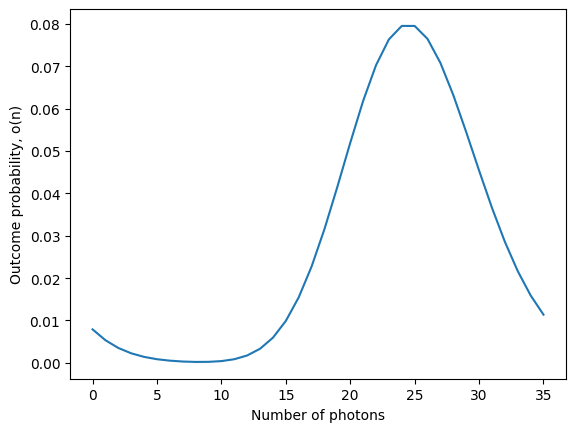

In [31]:
import matplotlib.pyplot as plt
source = Source.shaped_laser(parameters={'amplitude': 5})
p = Processor() // source // Detector.pnr(resolution=35)
pn = p.probs()
plt.plot(pn.keys(), pn.values())
plt.xlabel('Number of photons')
plt.ylabel('Outcome probability, o(n)')
plt.show()

## Threshold

In some cases, it is not necessary to fully resolve the number of photons. For example, some post-selected linear-optical gates only require the observation of zero photons. Another example is that of measuring the Hong-Ou-Mandel visibility, where it is only necessary to verify the absence of light to estimate a high indistinguishability. A threshold detector (also called an on/off detector) provides the probability of observing at least one photon at that detector during the detector gate time, and after accounting for detector inefficiency.

A threshold detector never experiences aliasing because it requires no truncation.

In [32]:
source = Source.shaped_laser(parameters={'amplitude': 1})
p = Processor() // source // Detector.threshold()
p.probs().display()

Pattern | Probability
0       | 0.36790
1       | 0.63211



## Vacuum

A vacuum detector is a fictitious detector that returns only the outcome corresponding to measuring zero photons, thus potentially speeding up the simulation. This is particularly useful when looking at the behaviour of a circuit conditioned on that absence of light at a certain detector. However, because it ignores all cases where photons arrived, the resulting distribution is not normalised.

In [33]:
source = Source.shaped_laser(parameters={'amplitude': 2})
p = Processor() // source // Circuit.bs() // (0, Detector.vacuum()) // (1, Detector.pnr(5))
p.probs().display()

Pattern | Expectation
0 0     | 0.01995
0 1     | 0.03710
0 2     | 0.03675
0 3     | 0.02445
0 4     | 0.01222
0 5     | 0.00488



## Parity

As introduced in the [Wigner Functions](wigner_functions.ipynb) advanced tutorial, the parity detector returns the parity expectation value of the detected photon number distribution. This can be used to obtain the value of the light's Wigner function at the origin of phase space.

Instead of an integer, the outcome of the parity detector is labeled with 'p'.

In [34]:
source = Source.shaped_laser(parameters={'amplitude': 1})
p = Processor() // source // Circuit.bs() // Detector.parity()
p.probs().display()

Pattern | Expectation
p       | 0.36790



The parity detector can also be combined with the 'pnr' detector type to get conditional measurements of the parity expectation value.

In [35]:
source = Source.shaped_laser(parameters={'amplitude': 1})
p = Processor() // Source.fock(1) // Circuit.bs() // Detector.parity() // (1, Detector.pnr(3))
pn = p.probs()
pn.display()

Pattern | Expectation
p 0     | -0.50000
p 1     | 0.50000



By splitting a photon on a beam splitter, we can see that the sign of the parity of the first output depends on the number of photons detected at the second output. These values are also multiplied by the probability of detection, which is 1/2 for each outcome using a balanced beam splitter.

## Time Partition

Many simulations of photonic experiments consider correlations between light emitted at different times. For example, see the [Fibonacci States](fibonacci_states.ipynb) and [Entanglment Generation](entanglement_generation.ipynb) tutorials. The way this can be done in ZPGenerator is to add a detector that partitions time into different bins.

To partition time, we can simply pass a list of times that define the thresholds between time bins. When photons are detected among these thresholds will determine which bin they will be tallied into. Note that photons that arrive anytime before the first threshold are neglected but photons that arrive anytime after the last threshold will be put into the last bin. Thus, there are as many bins as there are thresholds.

Let's split a single photon into four bins defined by intervals (0, 1), (1, 2), (2, 3), and (3, $\infty$).

In [36]:
d = Detector.partition(thresholds=[0, 1, 2, 3])
p = Processor() // Source.fock(1) // d
p.probs().display()

Pattern | Probability
1 0 0 0 | 0.63212
0 0 1 0 | 0.08555
0 1 0 0 | 0.23254
0 0 0 1 | 0.04979



This shows that single photons display single-particle anti-bunching in time as well (in addition to the common spatial description using the Hanbury and Brown Twiss setup). Coherent states display no such behaviour.

In [37]:
d = Detector.partition(thresholds=[0, 1, 2, 3])
p = Processor() // Source.shaped_laser(parameters={'amplitude':1}) // d
p.probs().display()

Pattern | Probability
0 0 0 0 | 0.45817
1 0 0 0 | 0.25635
0 0 1 0 | 0.03910
1 0 1 0 | 0.02188
0 1 0 0 | 0.10466
1 1 0 0 | 0.05856
0 1 1 0 | 0.00893
1 1 1 0 | 0.00500
0 0 0 1 | 0.02277
1 0 0 1 | 0.01274
0 0 1 1 | 0.00194
1 0 1 1 | 0.00109
0 1 0 1 | 0.00520
1 1 0 1 | 0.00291
0 1 1 1 | 0.00044
1 1 1 1 | 0.00025



If one requires the time bins to not be adjacent, the explicit intervals can also be given as a list of lists.

In [38]:
d = Detector.partition(thresholds=[[0, 0.5], [1, float('inf')]])
p = Processor() // Source.fock(1) // d
p.probs().display()

Pattern | Probability
0 0     | 0.23865
1 0     | 0.39347
0 1     | 0.36788



Note that in this case there is a probability of observing no photons because there is a chance they are emitted between the two time bins (between $t=0.5$ and $t=1$).

The measurement within each bin defaults to behave like a threshold detector, but we can specify a resolution to get number-resolving behaviour as well. Note that the resolution is applied to all detectors.

In [39]:
d = Detector.partition(thresholds=[0, 1], resolution=2)
p = Processor() // Source.fock(2) // d
p.probs().display()

Pattern | Probability
2 0     | 0.39958
1 1     | 0.46509
0 2     | 0.13533

